In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv')

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
df.head()

,laptop,status,brand,model,cpu,ram,storage,storage_type,gpu,screen,touch,final_price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [5]:
df_filtered = df[['ram', 'storage', 'screen', 'final_price']]

In [6]:
df_filtered.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


<Axes: xlabel='final_price', ylabel='Count'>

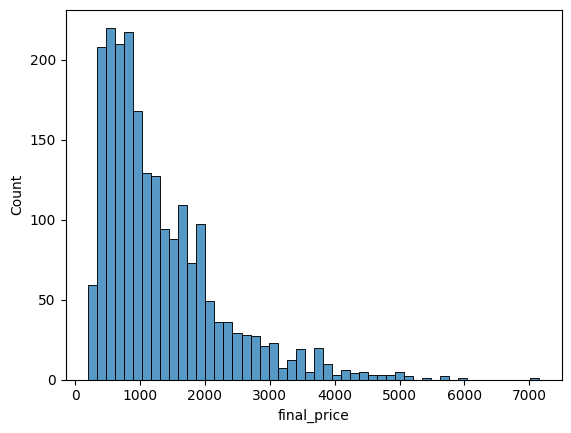

In [7]:
sns.histplot(df.final_price, bins=50)

# Question 1

In [8]:
df_filtered.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

# Question 2

In [9]:
df_filtered['ram'].median()

np.float64(16.0)

## Prepare and split the dataset

In [10]:
n = len(df_filtered)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [11]:
n_train, n_val, n_test, n

(1296, 432, 432, 2160)

In [12]:
idx = np.arange(n)

In [13]:
np.random.seed(42)
np.random.shuffle(idx)

In [14]:
df_train = df_filtered.iloc[idx[:n_train]]
df_val = df_filtered.iloc[idx[n_train:n_train+n_val]]
df_test = df_filtered.iloc[idx[n_train+n_val:]]

In [15]:
len(df_train), len(df_val), len(df_test)

(1296, 432, 432)

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = np.log1p(df_train.final_price.values)
y_val = np.log1p(df_val.final_price.values)
y_test = np.log1p(df_test.final_price.values)

In [18]:
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [19]:
len(y_train)

1296

# Question 3

In [20]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [21]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [22]:
def prepare_X(df, fillna_value):
    df = df.fillna(fillna_value)
    X = df.values
    return X

## with mean

In [23]:
mean = df_train.screen.mean()

X_train = prepare_X(df_train, fillna_value=mean)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, fillna_value=mean)
y_pred = w_0 + X_val.dot(w)

rmse(y_val, y_pred)

np.float64(0.4311767801693919)

## with zero

In [24]:
X_train = prepare_X(df_train, fillna_value=0)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, fillna_value=0)
y_pred = w_0 + X_val.dot(w)

rmse(y_val, y_pred)

np.float64(0.4288635315474416)

# Question 4

In [25]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [26]:
X_train = prepare_X(df_train, fillna_value=0)
X_val = prepare_X(df_val, fillna_value=0)

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)

    y_pred = w_0 + X_val.dot(w)
    score = rmse(y_val, y_pred).round(2)
    
    print(r, score)

0 0.43
0.01 0.43
0.1 0.43
1 0.43
5 0.46
10 0.51
100 0.67


# Question 5

In [27]:
res = {}

In [28]:
for i in range(0,9):
    np.random.seed(i)
    np.random.shuffle(idx)
    df_train = df_filtered.iloc[idx[:n_train]]
    df_val = df_filtered.iloc[idx[n_train:n_train+n_val]]
    df_test = df_filtered.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = np.log1p(df_train.final_price.values)
    y_val = np.log1p(df_val.final_price.values)
    y_test = np.log1p(df_test.final_price.values)

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    X_train = prepare_X(df_train, fillna_value=0)
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val, fillna_value=0)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)

    res.update({i: score})

In [29]:
res

{0: np.float64(0.453688995197294),
 1: np.float64(0.4266127011048473),
 2: np.float64(0.4485629615953571),
 3: np.float64(0.4237138219642778),
 4: np.float64(0.4485754254536311),
 5: np.float64(0.4577521649053766),
 6: np.float64(0.4457331112671798),
 7: np.float64(0.4385202775813915),
 8: np.float64(0.45316672579382355)}

In [30]:
values = list(res.values())

In [31]:
std_dev = np.std(values).round(3)
print(std_dev)

0.011


# Question 6

In [32]:
np.random.seed(9)
np.random.shuffle(idx)
df_train = df_filtered.iloc[idx[:n_train]]
df_val = df_filtered.iloc[idx[n_train:n_train+n_val]]
df_test = df_filtered.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.final_price.values)
y_val = np.log1p(df_val.final_price.values)
y_test = np.log1p(df_test.final_price.values)

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

X_full_train = prepare_X(df_full_train, fillna_value=0)
y_full_train = np.concatenate([y_train, y_val])
w_0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

X_test = prepare_X(df_test, fillna_value=0)
y_pred = w_0 + X_test.dot(w)

result = rmse(y_test, y_pred)
print(result)

0.4623254951019688
